# Evaluation Metrics for Classification

### 4.1 Evaluation metrics: session overview

We will use data and example from previous week and leave the final model here

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [4]:
!wget $data

--2022-10-03 12:24:56--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: 'WA_Fn-UseC_-Telco-Customer-Churn.csv.18'

     0K .......... .......... .......... .......... ..........  5% 1,19M 1s
    50K .......... .......... .......... .......... .......... 10%  591K 1s
   100K .......... .......... .......... .......... .......... 15% 1,07M 1s
   150K .......... .......... .......... .......... .......... 20%  868K 1s
   200K .......... .......... .......... .......... .......... 26%  325K 1s
   250K .......... .......... .......... .......... .......... 31% 2,11M 1s
   30

In [5]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [8]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [9]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### 4.2 Accuracy and dummy model

+ we will answer the questions if this 80% acuuracy achieved in the model is good enough or not


Taking our previous example of predicting if customer will churn or not. Imagine that we make three right predictions on customer churning, then our accuaracy (or fraction of correct predicitons will be 3/6 = 50%). 

If we take all validation set customers and assign score to each customers. Then we can decide if this customer will churn or not. 

In [11]:
# let's see how many correct decisions were made:
len(y_val)

1409

In [12]:
(y_val == churn_decision).sum() # no. of correct decisions 

1132

### Thus, accuracy is total No. of correct predicitons / No. of total customers


In [13]:
1132/1409

0.8034066713981547

In [14]:
# let's shift the threshold, use linspace and provide an arry of threshold

thresholds = np.linspace(0, 1, 21)


# here we will evaluate our predictions at 21 different thresholds
scores = []

for t in thresholds:
    #score = accuracy_score(y_val, y_pred >= t)
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)
# we can see that 0.5 is actually the best threshold giving 80% accuracy score    
# the accuray goes down when we move away from this threshold

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [15]:
scores # for each threshold we have a score

[0.2739531582682754,
 0.5088715400993612,
 0.5911994322214337,
 0.6664300922640171,
 0.7097232079489,
 0.7388218594748048,
 0.7601135557132718,
 0.7721788502484032,
 0.7849538679914834,
 0.7934705464868701,
 0.8034066713981547,
 0.801277501774308,
 0.794889992902768,
 0.7863733144073811,
 0.7650816181689141,
 0.7444996451383961,
 0.7345635202271115,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246]

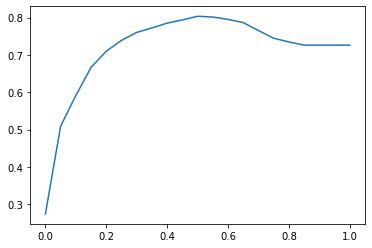

In [16]:
# let's plot these thresholds against scores
plt.plot(thresholds, scores)

+ 0.5 is the best threshold
+ logistic regression optimises and provides us with best threshold but still we should explore

In [17]:
# we can also juts use accuracy score function from scikit learn

from sklearn.metrics import accuracy_score

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [18]:
from collections import Counter

In [19]:
Counter(y_pred >= 1.0) # these customers are not churning

Counter({False: 1409})

+ The accuaryc doesn't tell us how good the model is
+ Imagine if we build a dummy model in which the decision cutoff is 1, so the algorithm predicts that no clients will churn, the accuracy would be 73%. 
+ Thus, the improvement of the original model with respect to the dummy model is not as high as we would expect.
+ Therefore, here accuracy can not tell us how good is the model because the dataset is unbalanced.
+ Imbalance is because there are 70% customers who are not churning, we have a lot of customers who are not churning as compared to the customers who are chunring. In such cases we have class imbalance.
+ Class imbalance means to have more instances from one category than the other.
+ Thus, class imbalance cases are quite misleadig. There are other ways of evaluating binary classification models in addition to accuracy which are more useful when we have to deal with problems with class imbalance. 

### 4.3 Confusion Table

There are following possible outcomes from the prediction of probability of a customer churning/not churning:

* Churn(Positive class)
    + if $g(x{i})$ >= threshold -> Positive -> Churn -> 1. Customer didn't churn (False positive), 2. Customer churned (True positive)
    + False Positive (FP) or True Positive (TP)
    
* Not Churning(Negative class)    
  + if $g(x{i})$ < threshold -> Negative -> Not Churning -> 1. Customer didn't churn (True negative), 2. Customer churned (False negative)
    + True Negative (TN) or False Negative (FN)

* $g_(x{i})$ >= t & y = 1; True Positive (TP)-> when we predicted that our customers are churning and indeed they are churning & our prediction is above the threshold

* $g_(x{i})$ < t & y = 0; True Negative (TN) -> when prediciton is that customer is not churning and they don't churn

* $g_(x{i})$ < t & y = 1; False Negative (FN) -> prediciton is that customer is not going to churn but they are churning. Prediction is negative but actual label is positive.

* $g_(x{i})$ >= t & y = 0; False Positive (FP) -> prediction is that customer is churning but they don't churn. The prediciton is positive but actual label is negative.

In [20]:
# implementing confusion table in NumPy
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [21]:
# a binary array
actual_positive

array([False, False, False, ..., False,  True,  True])

In [22]:
t = 0.5
predict_positive = (y_pred >=t)
predict_negative = (y_pred <t)

In [23]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [24]:
tp,tn

(210, 922)

In [25]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [26]:
fp,fn

(101, 176)

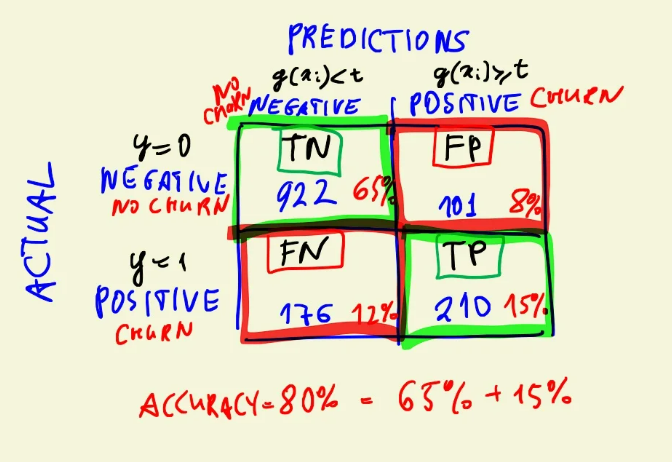

In [27]:
# creating this table in NumPy
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [28]:
# normalising -> instead of having absolute numbers, we will use relative numbers
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [29]:
(tp+tn) /(tp+tn+fp+fn)

0.8034066713981547

**Thus, accuracy is calculated by the sum of the TN & TP divided by the total number of observation**

**Using confusion table, we can get better understanding of what kind of correct/incorrect predictions are made by the model. Thus, confusion table helps us to understand quality of the model by using different scenarios**

### 4.4 Precision & Recall

**Precision & recall are matrix for evaluating binary classification models**
+ Precision informs us how many predicitons turned out to be correct
+ Precision is fraction of positive predictions that are correct
+ It considers parts of the all positive classes of the confusion matrix & can be calculated as follows:

$$
   \frac{TP}{TP+FP} 
$$

**Recall is fraction of correctly identified positive examples**
+ Recall measures the fraction of correctly identified postive classes. 
+ It takes into account the postive and negative classes (TP & FN ) & can be calculated as:

$$
   \frac{TP}{TP+FN} 
$$

In [30]:
p = tp/(tp+fp)
p

0.6752411575562701

In [31]:
tp+fp

311

In [32]:
r = tp/(tp+fn)
r

0.5440414507772021

 + In this example, precision informed us that there are 67% customers who were correctly identified as churning but 33% of them were incorrectly identified.
 
 + Recall informed us that there are 54% customers who were correctly identified as churning but 46% of them were failed to identify.
 
 + However, accuray was 80% which shows that the model was pretty well but precision & recall told us that there were 33% of customers who received promotional email who were not going to churn and the most important that 46% of customers were failed to be identified as churning customers and did not receive any promotional email.
    
 + Thus, precision & recall reflect some errors in the model which accuracy couldn't identify  because of the the class imbalance.

✍🏽Confuson table is a way to measure different types of correct decisions & errors a #binaryclassification #ml model can make.



✍🏽 The quality of the #ml model can be evaluated by using the confusion table. In the example of the customer churning project, there are four possible probabilities of customer churning:



  🟥No churn - Negative class

    True Negative (TN)-> Customer did not churn 

     False Negative (FN) -> Customer churned  



🟩 Churn - Positive class

    True Positive (TP) -> Customer churned 

    False Positive (FP) -> Customer did not churn



✍🏽Accuracy of the #ml model can be calculated by the sum of the TN & TP divided by the total number of observations (TP+TN+FP+FN).



🔶Precision & recall are matrices for evaluating binary classification models

🔶Precision informs about how many predictions turned out to be correct. Thus, precision is a fraction of positive predictions that are correct

🔶Precision considers parts of all positive classes of the confusion matrix & can be calculated as follows: TP / TP+FP





🔷Recall is the fraction of correctly identified positive examples

🔷 It measures the fraction of correctly identified positive classes

🔷 It takes into account the positive and negative classes (TP & FN ) & can be calculated as TP/TP+FN



  ⭐️ Thus, precision & recall reflect some errors in the model that accuracy couldn't identify because of the class imbalance.

#### Precision of 80% tells us that

🔸 80% of these customers indeed churn. If we offer them a discount and they use it, we're not losing money
🔸 20% of them will not churn. We offer them a discount and they use it. We're losing money

#### Recall

🔸 How many customers ended up churning?
🔸 How many of them the model could identify correctly?

### 4.4 ROC( Receiver Operating Characteristics)

🔵 ROC is a way of describing performance of a binary classification model
🔵 ROC was used in WW II for evaluating the strength of radar detectors. For example, there is a radar & a plane and radar wants to detect the plane. This is a machine learning problem. In this example, we can think if y = 1 that means plane is there or when y = 0, that means plane is not there. The features in this case are the signals from the radar. Thus, we want to understand from the signals of the radar,  if there is a plane flying over radar or not.
🔵 ROC curve considers False Positive Rate (FPR) & True Positive Rate (TPR) derived from the confusion matrix.

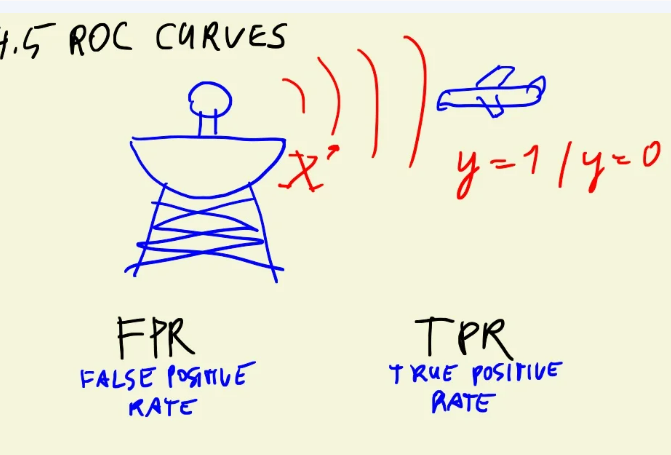

    🔹 FPR is the fraction of all false positives among all negative examples (i.e., users that didn't churn)
             FPR = FP/TN+FP
    🔹 TPR is the fraction of all true positive examples  TPR = TP/FN+TP
    
🔵   The aim here would be to maximize the TP part and minimize the FP part 

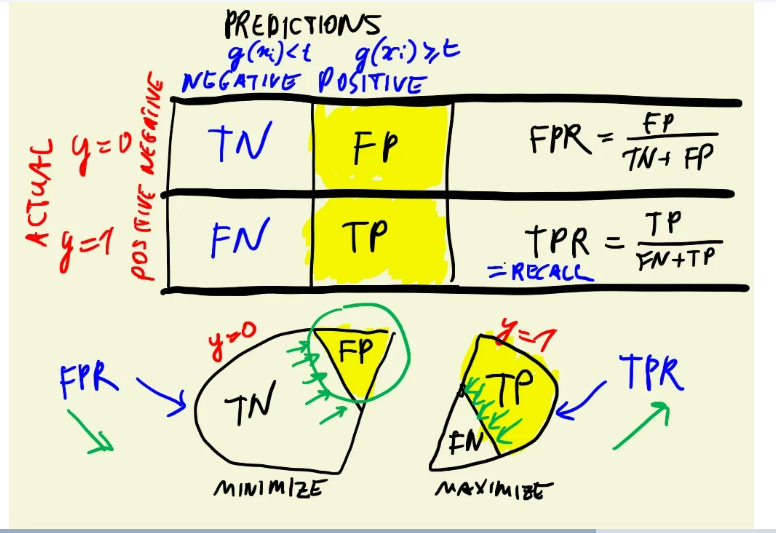

### TPR & FPR

In [33]:
tpr = tp/(tp+fn)
tpr

0.5440414507772021

In [34]:
# tpr is exactly the same as recall
r

0.5440414507772021

In [35]:
fpr = fp/(fp+tn)
fpr

# this means 10% are the incorrect predictions

0.09872922776148582

#### Benefits of using ROC curves

Instead of using only tpr & fpr for only one threshold values i.e., t = 0.5, we can use a range of threshold values with ROC curves. ROC curve will evaluate tpr & fpr values for each value of threshold.

In [36]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # put all these values in a data frame
    scores.append((t,tp,fp,fn,tn))

In [37]:
# these are basically confusion matrix evaluated for 101 values 
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 912, 1, 111),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 354, 453, 32, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 303, 70, 720),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [38]:
# turning this tuple into a data frame
columns = ['threshold','tp','fp','fn','tn']
df_Scores = pd.DataFrame(scores, columns = columns)

In [39]:
# printing every 10th record
df_Scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,75,20,311,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [40]:
# calculating tpr & fpr
df_Scores['tpr'] = df_Scores.tp / (df_Scores.tp + df_Scores.fn)
df_Scores['fpr'] = df_Scores.fp / (df_Scores.fp + df_Scores.tn)

In [41]:
df_Scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,75,20,311,1003,0.194301,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


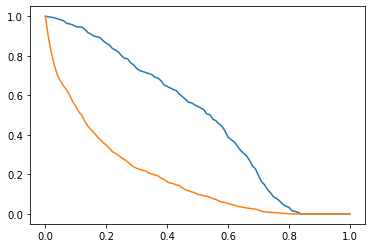

In [42]:
plt.plot(df_Scores.threshold, df_Scores['tpr'], label = 'TPR')
plt.plot(df_Scores.threshold, df_Scores['fpr'], label = 'FPR')

### Random model
we will create a random dummy model which will make decisions if this customer is going to churn or nor completely randomly

In [43]:
# assigning every customer a random score between 0 & 1 on validation dataset
# fixing the random seed
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))

In [44]:
y_rand # these are the predicitons

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [45]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [46]:
# accuracy for this model
((y_rand >= 0.5) == y_val).mean()
# this is epxected, as 5% got correct predictions by luck

0.5017743080198722

In [47]:
def tpr_fpr_dataframe(y_val,y_pred):
    scores = []

    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        # put all these values in a data frame
        scores.append((t,tp,fp,fn,tn))

    columns = ['threshold','tp','fp','fn','tn']
    df_Scores = pd.DataFrame(scores, columns = columns)  
    
    df_Scores['tpr'] = df_Scores.tp / (df_Scores.tp + df_Scores.fn)
    df_Scores['fpr'] = df_Scores.fp / (df_Scores.fp + df_Scores.tn)
    
    return df_Scores

In [48]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [49]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


<function matplotlib.pyplot.legend(*args, **kwargs)>

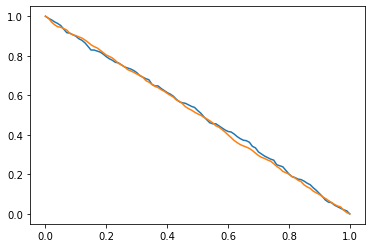

In [50]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend

### Ideal model

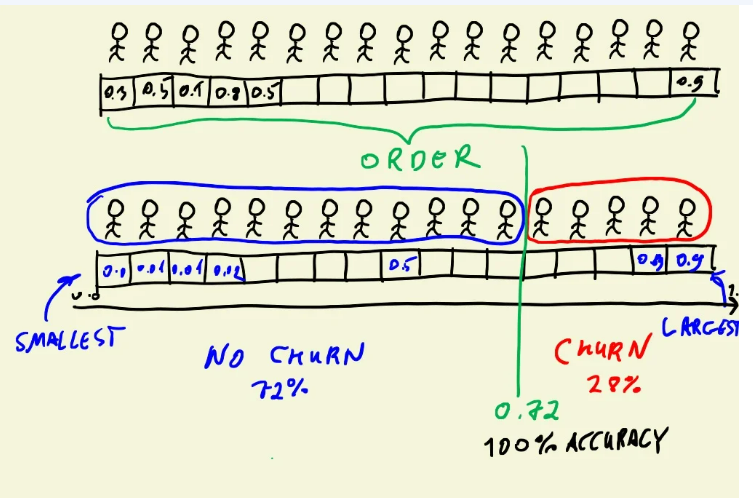

In [51]:
# number of customers who are not churning (based on the picture example)
num_neg = (y_val == 0).sum()

# number of customers who are churning
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [52]:
# contain only negtaive /positive observations
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal

# these are actual prediction values telling us if customer is churning or non-churning
# this is kind of our validation set

array([0, 0, 0, ..., 1, 1, 1])

In [53]:
# creating our prediction which can be numbers between 0 & 1

# this is the actual prediction for the classifier
y_ideal_pred = np.linspace(0,1,len(y_val))

In [54]:
1 - y_val.mean()


0.7260468417317246

In [55]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [56]:
df_ideal = np.linspace(0,1,len(y_val))

This is how ideal models look like which do not exist in reality but they help us to benchmark our models against the ideal one.

In [57]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

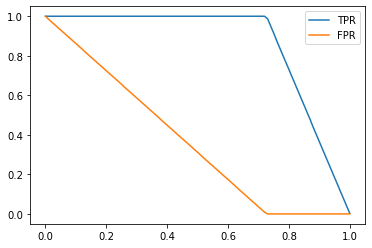

In [58]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR')
plt.legend()

### Putting everything together

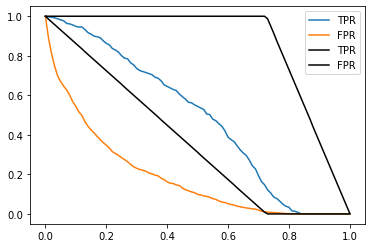

In [59]:
plt.plot(df_Scores.threshold, df_Scores['tpr'], label = 'TPR')
plt.plot(df_Scores.threshold, df_Scores['fpr'], label = 'FPR')

#plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR', color ='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR',color ='black')


plt.legend()



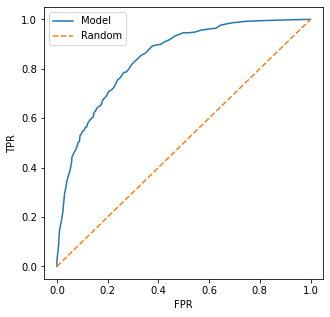

In [60]:
plt.figure(figsize=(5, 5))

plt.plot(df_Scores.fpr, df_Scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

**A better model will always be close to the ideal model
However, if a model is close to the random model, then it's not better. Thus, the model should not below the random itself.**

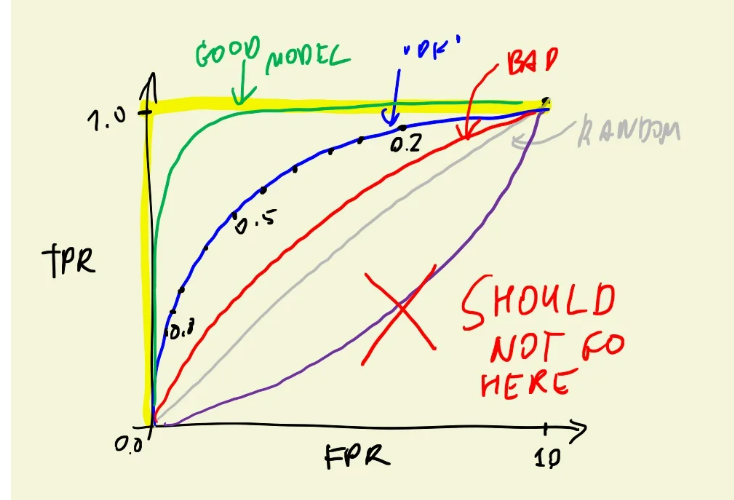

In [61]:
# roc curve with scikit learn

from sklearn.metrics import roc_curve


In [62]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

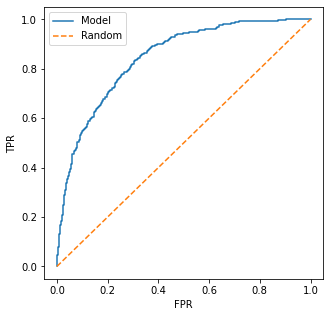

In [63]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### ROC AUC

#### (A)rea (U)nder the ROC (C)urve
#### AUC is a useful metric for evaluating binary classification models

+ Our aim is to be as close as to the ideal model. That means TPR being close to 1 and FPR close to 0
+ AUC is a way to find out how close we are to the ideal point i.e., 1
+ The model performance evaluation can be done by looking at the AUC. If the AUC is large near the ideal point let's say 0.9 then the model performance is great but if it is 0.8 and slightly far away from the ideal value, then it is an OK performance.

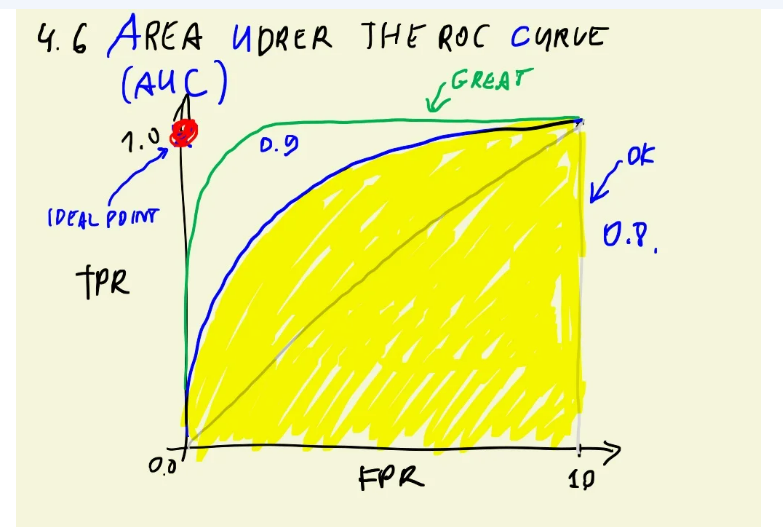

+ The model needs to be between the random model (the left figure with straight line) & the ideal curve (the right side figure close to the 1).
+ These two i.e., random model & ideal curve are like our baseline models

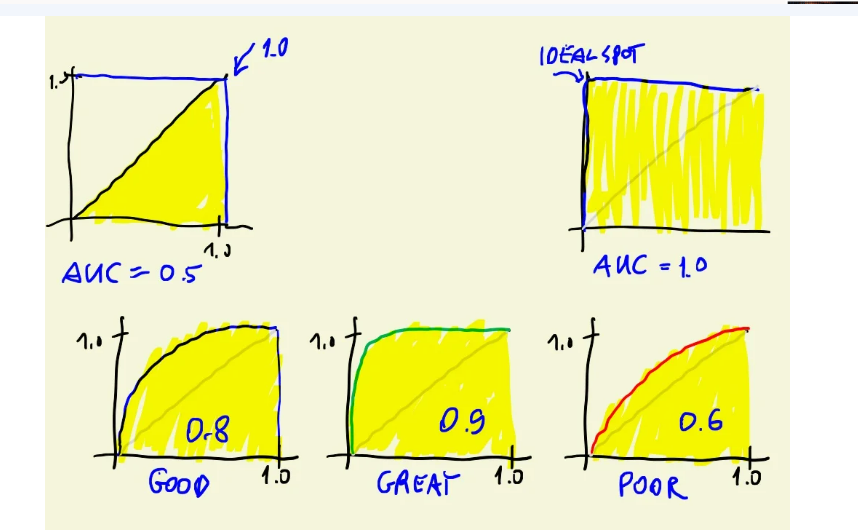

#### Thus, by using AUC we can evaluate the performance of our model by seeing how far it is from the random model and how close it is to the ideal curve.

In [64]:
# AUC calculation using scikit learn

from sklearn.metrics import auc # this is not just for calculating ROC curves but any curve

In [65]:
auc(fpr,tpr)

0.843850505725819

In [67]:
# our model
auc(df_Scores.fpr, df_Scores.tpr)

# our model is very close to the auc score above that means our model is pretty accurate

0.8438213828068416

In [68]:
# calculating AUC manually
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(df_Scores.fpr, df_Scores.tpr)

0.8438213828068416

In [70]:
# using the sklearn
from sklearn.metrics import roc_auc_score

In [71]:
roc_auc_score(y_val,y_pred)

0.843850505725819

### AUC interpretation

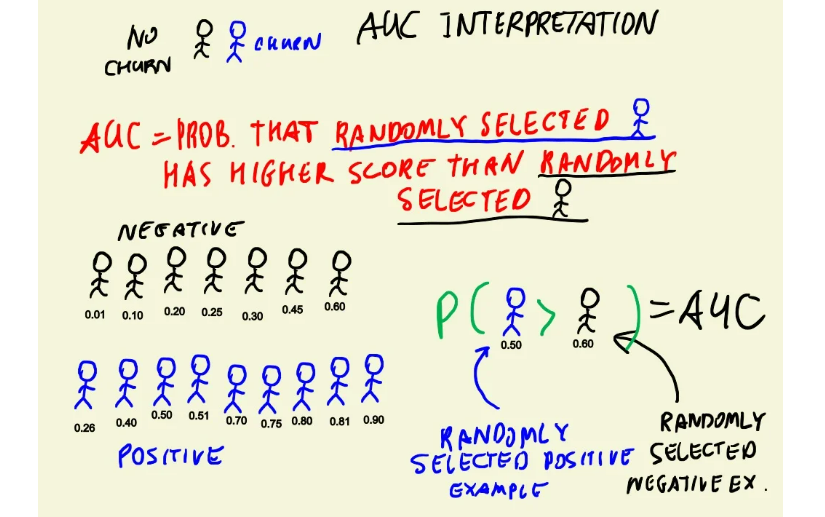

**If we take all positive (customers churning) and negative (customers not churning) cases in this example. Then the AUC tells us what is the probability that randomly selected positive cases have a score that is higher than the randomly selected negative cases.**

In [72]:
# applying it into code
pos = y_pred[y_val == 1]
neg = y_pred[y_val == 0]

In [73]:
import random

In [74]:
pos_ind = random.randint(0,len(pos)-1)
neg_ind = random.randint(0,len(neg)-1)

In [77]:
# comapring the scores of negative and positive cases (repeating them many times)
n = 100000
success = 0


for i in range(n):
    pos_ind = random.randint(0,len(pos)-1)
    neg_ind = random.randint(0,len(neg)-1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success +1
        
success / n        

0.84383

*We randomly selected positive & negative cases and compared them (to check if positive cases are higher than the negative cases) 100000 times. Then we saw the total number of fraction when this is true is 84%.*

*This tells us how well our model ordered customers perfectly.*

In [78]:
# implementing above thing in numpy
pos_ind = np.random.randint(0,len(pos),size=n)
neg_ind = np.random.randint(0,len(neg),size=n)

In [79]:
# randomly selected negative & positive cases
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0,len(pos),size=n)
neg_ind = np.random.randint(0,len(neg),size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

### Cross-Validation

🔶 Parameter tuning is the process of selecting the best parameter

#### K-Cross-Validation

🔶 As we divide the data into three parts: TRAIN/VALIDATION/TEST and then we use the validation set to find the best parameter for our model $g(x{i})$.
🔶 But this is not the only way of validating our models. Let's say if we keep the test set aside and then combine TEST+VALIDATION set and call it FULL TRAIN.
🔶 Let's say we split the FULL TRAIN into k parts, let's say k=3. Then we use part 1 & 2 to train model and use part 3 to evaluate the model. In this way, we can train models on different combinations of the parts of the models and evaluate on the third left part as follows:

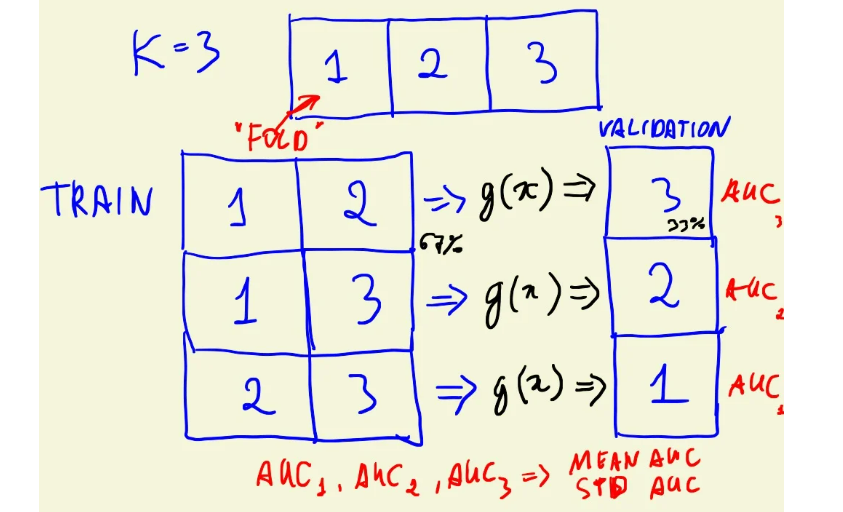



🔶 As a result, we get three AUC scores and compute the mean & the standard deviation of the AUC scores.
🔶 The standard deviation will show us how stable the model is and how much the AUC scores differ across different folds.
🔶 This entire process is called fold.

##### creating train function

In [105]:

def train(df, y_train, C =1.0):
    dicts = df[categorical +numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse= False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C,max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model 

In [106]:
dv, model = train(df_train, y_train, C =0.001)

#### creating a predict function

In [85]:


def predict(df,dv, model):
    dicts = df[categorical +numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred 

In [86]:
y_pred = predict(df_val,dv,model)

#### creating k-fold cross validation object

In [89]:
from sklearn.model_selection import KFold

In [90]:
kfold = KFold(n_splits = 10, shuffle = True, random_state =1)

In [91]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [92]:
len(train_idx), len(val_idx)

(5070, 564)

In [93]:
len(df_full_train)

5634

 Now we will:
 + extract the dictionary
 + feed the dictionary vectoriser 
 + extract the feature matrix
 + train the model

#### Parameter tuning

+ It is equivalent to the regularization parameter 
+ passing it to the Logistic regression function

In [107]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.840 +- 0.008
C=0.5 0.841 +- 0.006
C=1 0.841 +- 0.009
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [95]:
# to check the progress of each iteration

!pip install tqdm

In [96]:
from tqdm.auto import tqdm 

In [108]:
# these are the scores from each fold
scores

[0.8419315336248243,
 0.8457261455436365,
 0.8325466586393739,
 0.8320150124704228,
 0.8525462018763139]

In [99]:
# computing mean scores and standard deviation

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.841 +- 0.012


#### training our final model

In [109]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

#### when to use cross validation
+ When the dataset is quite large, we can use the usual hold out dataset division
+ If the dataset is smaller and if we also want to find out the standard deviation to see how stable our model is and how much it varies for different folds, then it makes sense to use k fold cross validation
+ For a larger dataset, the number of splits will be around 2-3 & for the smaller dataset the splits can be around 10 or more